Cumulative variance explained by 100 components: 0.63


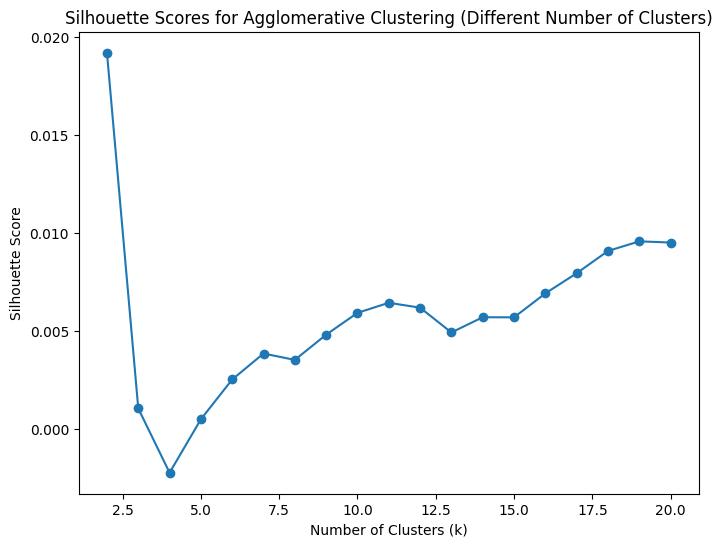

Optimal number of clusters: 2
Cluster sizes:
1    1161
0     954
Name: count, dtype: int64


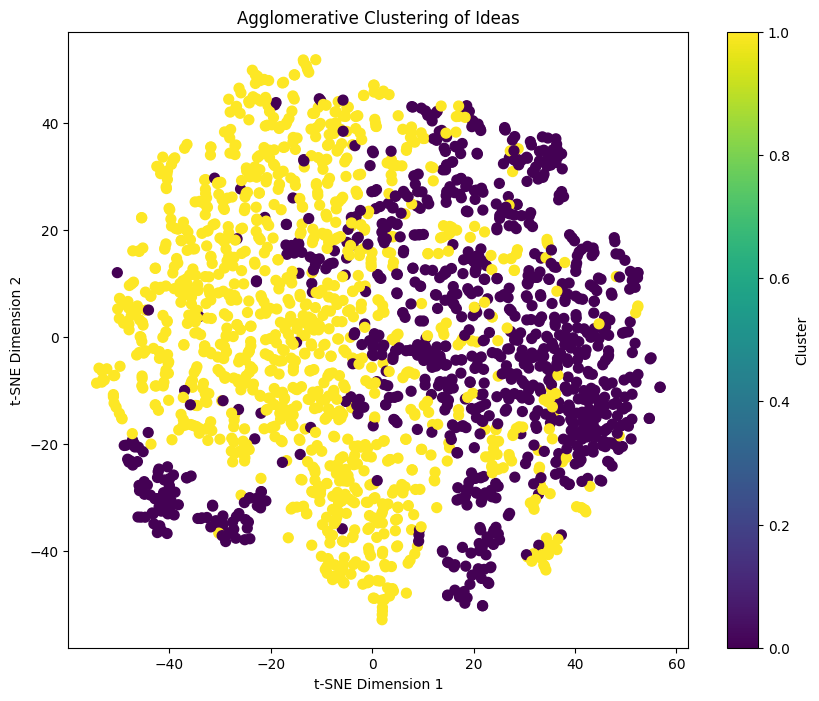


Cluster 0 contains 954 ideas.
Top Categories:
Enhancement             680
New Feature Concept      95
Quick Win                41
System Configuration     36
Whiteboard               18
Name: count, dtype: int64

Top Statuses:
New Submission           524
Implemented              174
Under Review             136
In Backlog                48
Not Currently Planned     39
Name: count, dtype: int64

Sample Titles:
['AI-First Whiteboard', 'Offer specific Hackathon exports ', 'Submission date on ideas in browse view ', 'Edit/updates to Blog posts', 'Set up user guide']

Cluster 1 contains 1161 ideas.
Top Categories:
Enhancement             823
New Feature Concept     110
Quick Win                63
System Configuration     48
Whiteboard               40
Name: count, dtype: int64

Top Statuses:
New Submission           652
Implemented              228
Under Review             126
In Backlog                79
Not Currently Planned     48
Name: count, dtype: int64

Sample Titles:
['Use Rules f

In [1]:
# Import necessary libraries
import os
import json
from dotenv import load_dotenv
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from pinecone.grpc import PineconeGRPC as Pinecone

# Load environment variables
load_dotenv()

# Set up Pinecone API key and initialize
pinecone_api_key = os.getenv("PINECONE_API_KEY")
if not pinecone_api_key:
    raise ValueError("PINECONE_API_KEY is not set in the .env file")

pc = Pinecone(api_key=pinecone_api_key)

index_name = 'idea-index'
namespace = os.getenv("PINECONE_NAMESPACE")
index = pc.Index(index_name)

# Use the describe_index_stats method to get metadata including total vectors
stats = index.describe_index_stats()
vector_count = stats["total_vector_count"]

all_ids = []

for ids in index.list(namespace=namespace):
    all_ids.extend(ids)

embeddings = []

# Step 1: Fetch embeddings in batches
batch_size = 500

for i in range(0, len(all_ids), batch_size):
    batch_ids = all_ids[i:i + batch_size]
    response = index.fetch(ids=batch_ids, namespace=namespace)
    # Extract only the "values" from each vector
    embeddings.extend([vector["values"] for vector in response["vectors"].values()])

# Convert embeddings to a NumPy array
embeddings = np.array(embeddings, dtype=np.float32)  # Ensure data type consistency

# Step 2: Dimensionality reduction
# First, scale the embeddings
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(embeddings)

# Use PCA for initial reduction to 100 dimensions
pca = PCA(n_components=100)
reduced_embeddings = pca.fit_transform(scaled_embeddings)

# Check variance explained by PCA components
explained_variance = np.sum(pca.explained_variance_ratio_)
print(f"Cumulative variance explained by 100 components: {explained_variance:.2f}")

# Use t-SNE for final 2D visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(reduced_embeddings)

# Step 3: Use Agglomerative Clustering
# AgglomerativeClustering doesn't require the number of clusters upfront like K-Means.
# We can try with a range of clusters and find the best number using silhouette score.

# Number of clusters can be a parameter, for example, from 2 to 20 clusters
k_values = range(2, 21)
silhouette_scores = []

for k in k_values:
    agglomerative = AgglomerativeClustering(n_clusters=k)
    labels = agglomerative.fit_predict(scaled_embeddings)
    score = silhouette_score(scaled_embeddings, labels)
    silhouette_scores.append(score)

# Plot the silhouette scores for each number of clusters
plt.figure(figsize=(8, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title("Silhouette Scores for Agglomerative Clustering (Different Number of Clusters)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.show()

# Step 4: Choose the optimal number of clusters based on silhouette scores
# Let's assume we choose the optimal k based on the highest silhouette score
optimal_k = k_values[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters: {optimal_k}")

# Perform Agglomerative Clustering with the optimal k
agglomerative = AgglomerativeClustering(n_clusters=optimal_k)
labels = agglomerative.fit_predict(scaled_embeddings)

# Analyze cluster sizes
cluster_sizes = pd.Series(labels).value_counts()
print(f"Cluster sizes:\n{cluster_sizes}")

# Step 5: Visualization with t-SNE results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='viridis', s=50)
plt.colorbar(scatter, label="Cluster")
plt.title("Agglomerative Clustering of Ideas")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

# Step 6: Fetch metadata from Pinecone and group by cluster
metadata_dict = {}

# Fetch metadata for all IDs in batches
for i in range(0, len(all_ids), batch_size):
    batch_ids = all_ids[i:i + batch_size]
    response = index.fetch(ids=batch_ids, namespace=namespace)
    for vector_id, vector_data in response['vectors'].items():
        metadata_dict[vector_id] = vector_data['metadata']

# Group metadata by cluster
cluster_metadata = {i: [] for i in range(optimal_k)}
for idx, label in enumerate(labels):
    vector_id = all_ids[idx]
    if vector_id in metadata_dict:  # Ensure metadata exists for this ID
        cluster_metadata[label].append(metadata_dict[vector_id])

# Display a summary of themes within each cluster
for cluster_id, metadata_list in cluster_metadata.items():
    print(f"\nCluster {cluster_id} contains {len(metadata_list)} ideas.")
    
    # Extract metadata fields for analysis
    categories = [meta['category'] for meta in metadata_list if 'category' in meta and meta['category']]
    statuses = [meta['status'] for meta in metadata_list if 'status' in meta and meta['status']]
    submitters = [meta['submitter'] for meta in metadata_list if 'submitter' in meta and meta['submitter']]
    
    # Count occurrences of categories and statuses
    category_counts = pd.Series(categories).value_counts()
    status_counts = pd.Series(statuses).value_counts()
    
    print("Top Categories:")
    print(category_counts.head(5))  # Display top 5 categories
    print("\nTop Statuses:")
    print(status_counts.head(5))  # Display top 5 statuses
    print("\nSample Titles:")
    print([meta['title'] for meta in metadata_list[:5] if 'title' in meta])  # Display a few sample titles

# Combine all metadata for each cluster
cluster_data = {}
for cluster_id, metadata_list in cluster_metadata.items():
    cluster_data[cluster_id] = metadata_list

# Save cluster data as JSON
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop", "agglomerative_cluster_files")
if not os.path.exists(desktop_path):
    os.makedirs(desktop_path)

# Save the cluster_metadata as JSON
json_file_path = os.path.join(desktop_path, "cluster_metadata.json")
with open(json_file_path, "w") as json_file:
    json.dump(cluster_metadata, json_file, indent=4)

# Optionally save each cluster to separate CSV files on the Desktop
for cluster_id, metadata_list in cluster_metadata.items():
    df = pd.DataFrame(metadata_list)
    csv_file_path = os.path.join(desktop_path, f"cluster_{cluster_id}.csv")
    df.to_csv(csv_file_path, index=False)
    print(f"Cluster {cluster_id} saved to {csv_file_path}")
